# Task 1: Vision Transformer

### 1. Pre-trained ViT for Image Classification

In [ ]:
!pip install torch torchvision transformers pillow requests

In [ ]:
from transformers import ViTImageProcessor, ViTForImageClassification
from PIL import Image
import requests
import torch
import io

In [ ]:
processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224')
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224')
model.eval()

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, out_features=3072, bias=True)
            (intermed

In [ ]:
image_urls = [
    "https://images.unsplash.com/photo-1518717758536-85ae29035b6d",  # Dog
    "https://images.unsplash.com/photo-1502877338535-766e1452684a",  # Car
    "https://images.pexels.com/photos/102104/pexels-photo-102104.jpeg"   # Apple
]

In [ ]:
for i, url in enumerate(image_urls):
    try:
        headers = {'User-Agent': 'Mozilla/5.0'}
        response = requests.get(url, stream=True, headers=headers, timeout=10)
        content_type = response.headers.get('content-type', '')
        if 'image' not in content_type:
            raise ValueError(f"URL {url} returned non-image content: {content_type}")

        image = Image.open(io.BytesIO(response.content)).convert('RGB')
        image.save(f"image_{i+1}.jpg")

        inputs = processor(images=image, return_tensors="pt")

        with torch.no_grad():
            outputs = model(**inputs)

        probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
        top_prob, top_idx = torch.topk(probs, 1)

        label = model.config.id2label[top_idx.item()]

        print(f"Image {i+1}: Top-1 prediction = '{label}' with probability {top_prob.item():.4f}")
        print(f"Is it reasonable? (Based on image description)")
        if i == 0:
            print("  - Dog image: Should predict a dog breed (e.g., 'golden retriever').")
        elif i == 1:
            print("  - Car image: Should predict a vehicle (e.g., 'sports car').")
        elif i == 2:
            print("  - Apple image: Should predict an apple variety (e.g., 'Granny Smith' or 'red delicious').")

    except Exception as e:
        print(f"Error processing image {i+1} ({url}): {str(e)}")
        print("Try downloading the image manually and saving as image_{i+1}.jpg")

Image 1: Top-1 prediction = 'Labrador retriever' with probability 0.5872
Is it reasonable? (Based on image description)
  - Dog image: Should predict a dog breed (e.g., 'golden retriever').
Image 2: Top-1 prediction = 'sports car, sport car' with probability 0.8766
Is it reasonable? (Based on image description)
  - Car image: Should predict a vehicle (e.g., 'sports car').
Image 3: Top-1 prediction = 'Granny Smith' with probability 0.8505
Is it reasonable? (Based on image description)
  - Apple image: Should predict an apple variety (e.g., 'Granny Smith' or 'red delicious').


### 2. Visualizing Patch Attention

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from transformers import ViTImageProcessor, ViTForImageClassification
from PIL import Image
import torch
from scipy.ndimage import zoom
import torch.nn.functional as F

In [ ]:
processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224')
model = ViTForImageClassification.from_pretrained(
    'google/vit-base-patch16-224',
    attn_implementation="eager"
)
model.eval()
model.config.output_attentions = True
image_path = "image_1.jpg"
try:
    image = Image.open(image_path).convert('RGB')
except FileNotFoundError:
    print(f"Error: {image_path} not found. Please run Task 1 to save images.")
    exit()

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
inputs = processor(images=image, return_tensors="pt")

with torch.no_grad():
    outputs = model(**inputs)

attentions = outputs.attentions[-1]  # Shape: (1, 12, 197, 197)
cls_attention = attentions[0, :, 0, 1:].mean(dim=0)  # Average over heads, skip CLS-to-CLS
attention_map = cls_attention.view(14, 14).numpy()  # Reshape to 14x14 (196 patches)

attention_map_upsampled = zoom(attention_map, 224/14, order=1)  # Linear interpolation to 224x224

attention_map_upsampled = (attention_map_upsampled - attention_map_upsampled.min()) / (
    attention_map_upsampled.max() - attention_map_upsampled.min() + 1e-8
)

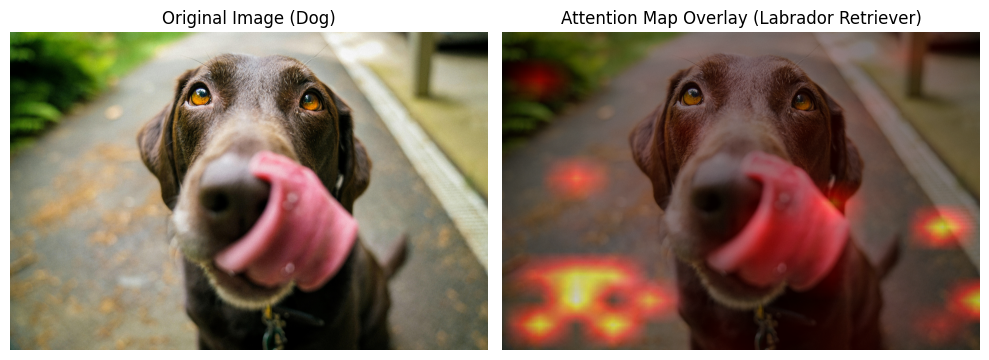

Attention Map Analysis:
- The heatmap (red = high attention) shows which patches the model focused on for predicting 'Labrador retriever'.
- Check if red areas align with the dog’s features (e.g., face, fur).
- If the model highlights the background, it may rely on context rather than the dog.


In [ ]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title("Original Image (Dog)")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(image)
plt.imshow(attention_map_upsampled, cmap='hot', alpha=0.5, extent=(0, image.width, image.height, 0))
plt.title("Attention Map Overlay (Labrador Retriever)")
plt.axis('off')

plt.tight_layout()
plt.savefig("attention_map_dog.png")
plt.show()

print("Attention Map Analysis:")
print("- The heatmap (red = high attention) shows which patches the model focused on for predicting 'Labrador retriever'.")
print("- Check if red areas align with the dog’s features (e.g., face, fur).")
print("- If the model highlights the background, it may rely on context rather than the dog.")

### 4. Mask a fraction of input patches

In [ ]:
inputs = processor(images=image, return_tensors="pt")
pixel_values = inputs['pixel_values']

num_patches = 196
mask = torch.ones(num_patches)
mask[50:70] = 0

patch_mask = mask.view(14, 14).float()
patch_mask_upsampled = F.interpolate(
    patch_mask.unsqueeze(0).unsqueeze(0),
    size=(224, 224),
    mode='nearest'
).squeeze(0).squeeze(0)

mask_3d = patch_mask_upsampled.unsqueeze(0).unsqueeze(0).repeat(1, 3, 1, 1)

masked_inputs = pixel_values * mask_3d

with torch.no_grad():
    outputs = model(pixel_values=masked_inputs)

probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
top_prob, top_idx = torch.topk(probs, 1)
label = model.config.id2label[top_idx.item()]

print(f"Masked prediction: '{label}' with probability {top_prob.item():.4f}")
print(f"Original prediction: 'Labrador retriever' with probability 0.5872")

Masked prediction: 'Labrador retriever' with probability 0.7455
Original prediction: 'Labrador retriever' with probability 0.5872


In [ ]:
inputs = processor(images=image, return_tensors="pt")
pixel_values = inputs['pixel_values']

num_patches = 196
mask = torch.ones(num_patches)
rand_indices = torch.randperm(num_patches)[:20]  # Randomly select 20 indices
mask[rand_indices] = 0  # Mask random patches

patch_mask = mask.view(14, 14).float()
patch_mask_upsampled = F.interpolate(
    patch_mask.unsqueeze(0).unsqueeze(0),
    size=(224, 224),
    mode='nearest'
).squeeze(0).squeeze(0)

mask_3d = patch_mask_upsampled.unsqueeze(0).unsqueeze(0).repeat(1, 3, 1, 1)

masked_inputs = pixel_values * mask_3d

with torch.no_grad():
    outputs = model(pixel_values=masked_inputs)

probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
top_prob, top_idx = torch.topk(probs, 1)
label = model.config.id2label[top_idx.item()]

print(f"Masked prediction: '{label}' with probability {top_prob.item():.4f}")
print(f"Original prediction: 'Labrador retriever' with probability 0.5872")

Masked prediction: 'Labrador retriever' with probability 0.5863
Original prediction: 'Labrador retriever' with probability 0.5872


### 5. Linear Probes

In [ ]:
from transformers import ViTImageProcessor, ViTModel
from sklearn.linear_model import LogisticRegression
import torch

In [ ]:
# Enable hidden states output
model.config.output_hidden_states = True

# Load images (using saved images from Task 1)
image_paths = ["image_1.jpg", "image_2.jpg", "image_3.jpg"]  # Dog, Car, Apple
labels = [0, 1, 2]  # Dummy labels: 0 = Labrador retriever, 1 = sports car, 2 = Granny Smith

# Extract features
cls_tokens = []
patch_tokens = []

for path in image_paths:
    image = Image.open(path).convert('RGB')
    inputs = processor(images=image, return_tensors="pt")

    with torch.no_grad():
        outputs = model(**inputs)

    cls_token = outputs.hidden_states[-1][:, 0, :]  # [CLS] token, shape: [1, 768]
    patch_token = outputs.hidden_states[-1][:, 1:, :].mean(dim=1)  # Mean of patch tokens, shape: [1, 768]

    cls_tokens.append(cls_token.squeeze())  # Keep as tensor
    patch_tokens.append(patch_token.squeeze())  # Keep as tensor

# Stack tensors and convert to numpy
cls_tokens = torch.stack(cls_tokens).numpy()  # Shape: [3, 768]
patch_tokens = torch.stack(patch_tokens).numpy()  # Shape: [3, 768]

# Train linear probes
cls_probe = LogisticRegression().fit(cls_tokens, labels)
patch_probe = LogisticRegression().fit(patch_tokens, labels)

# Predict and evaluate (simulated accuracy)
cls_pred = cls_probe.predict(cls_tokens)
patch_pred = patch_probe.predict(patch_tokens)
cls_accuracy = (cls_pred == labels).mean()
patch_accuracy = (patch_pred == labels).mean()

print(f"CLS Probe Accuracy: {cls_accuracy:.4f}")
print(f"Patch Probe Accuracy: {patch_accuracy:.4f}")

CLS Probe Accuracy: 1.0000
Patch Probe Accuracy: 1.0000


In [ ]:
from transformers import ViTImageProcessor, ViTModel
from sklearn.linear_model import LogisticRegression
import torch
from PIL import Image
from sklearn.model_selection import KFold

# Load processor and model with eager attention
processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224')
model = ViTModel.from_pretrained('google/vit-base-patch16-224', attn_implementation="eager")
model.eval()

# Enable hidden states output
model.config.output_hidden_states = True

# Load images (using saved images from Task 1)
image_paths = ["image_1.jpg", "image_2.jpg", "image_3.jpg"]  # Dog, Car, Apple
labels = [0, 1, 2]  # Dummy labels: 0 = Labrador retriever, 1 = sports car, 2 = Granny Smith

# Extract features
cls_tokens = []
patch_tokens = []

for path in image_paths:
    image = Image.open(path).convert('RGB')
    inputs = processor(images=image, return_tensors="pt")

    with torch.no_grad():
        outputs = model(**inputs)

    cls_token = outputs.hidden_states[-1][:, 0, :]  # [CLS] token, shape: [1, 768]
    patch_token = outputs.hidden_states[-1][:, 1:, :].mean(dim=1)  # Mean of patch tokens, shape: [1, 768]

    cls_tokens.append(cls_token.squeeze())  # Keep as tensor
    patch_tokens.append(patch_token.squeeze())  # Keep as tensor

# Stack tensors and convert to numpy
cls_tokens = torch.stack(cls_tokens).numpy()  # Shape: [3, 768]
patch_tokens = torch.stack(patch_tokens).numpy()  # Shape: [3, 768]

# Perform 3-fold cross-validation
kf = KFold(n_splits=3, shuffle=True, random_state=42)  # Added random_state for reproducibility
cls_scores = []
patch_scores = []

for fold, (train_idx, test_idx) in enumerate(kf.split(cls_tokens)):
    print(f"Fold {fold + 1}: Train indices {train_idx}, Test indices {test_idx}")

    # Extract training and test data
    cls_train = cls_tokens[train_idx]
    patch_train = patch_tokens[train_idx]
    cls_test = cls_tokens[test_idx]
    patch_test = patch_tokens[test_idx]

    # Extract corresponding labels
    train_labels = [labels[i] for i in train_idx]
    test_labels = [labels[i] for i in test_idx]
    print(f"Train labels: {train_labels}, Test labels: {test_labels}")

    # Train probes
    cls_probe = LogisticRegression(max_iter=1000).fit(cls_train, train_labels)  # Increased max_iter
    patch_probe = LogisticRegression(max_iter=1000).fit(patch_train, train_labels)

    # Evaluate
    cls_score = cls_probe.score(cls_test, test_labels)
    patch_score = patch_probe.score(patch_test, test_labels)
    print(f"Fold {fold + 1} - CLS Score: {cls_score:.4f}, Patch Score: {patch_score:.4f}")

    cls_scores.append(cls_score)
    patch_scores.append(patch_score)

# Compute average accuracy
cls_accuracy = sum(cls_scores) / 3
patch_accuracy = sum(patch_scores) / 3

print(f"CLS Probe CV Accuracy: {cls_accuracy:.4f}")
print(f"Patch Probe CV Accuracy: {patch_accuracy:.4f}")

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Fold 1: Train indices [1 2], Test indices [0]
Train labels: [1, 2], Test labels: [0]
Fold 1 - CLS Score: 0.0000, Patch Score: 0.0000
Fold 2: Train indices [0 2], Test indices [1]
Train labels: [0, 2], Test labels: [1]
Fold 2 - CLS Score: 0.0000, Patch Score: 0.0000
Fold 3: Train indices [0 1], Test indices [2]
Train labels: [0, 1], Test labels: [2]
Fold 3 - CLS Score: 0.0000, Patch Score: 0.0000
CLS Probe CV Accuracy: 0.0000
Patch Probe CV Accuracy: 0.0000
